# setup

In [1]:
%load_ext autoreload
%autoreload 2

In [53]:
import re
from typing import Sequence
from tempfile import mkdtemp

import pandas as pd

from sklearn.pipeline import Pipeline

from src.io import CsvDataLoader
from src.preproc import RawDataCleaner, TextCleaner

pd.set_option('display.max_rows', 100)

# load raw data

In [54]:
pipe = Pipeline([
    ('load_data', CsvDataLoader(file_name='polish_sentiment_dataset.csv')),
    ('basic_cleaning', RawDataCleaner()),
    ('text_cleaning', TextCleaner(keep_digits=1, keep_punct=0)),
], memory=mkdtemp())

In [55]:
data = pipe.fit_transform(None)

/home/mic/Pulpit/pyProj/gensim/venv/lib/python3.8/site-packages/sklearn/pipeline.py:348: UserWarning: Persisting input arguments took 2.39s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


# basic eda

In [56]:
data.shape

(917525, 6)

In [57]:
data['negative'].value_counts(dropna=False)/len(data)

0.0    0.800228
1.0    0.199772
Name: negative, dtype: float64

<AxesSubplot:ylabel='Frequency'>

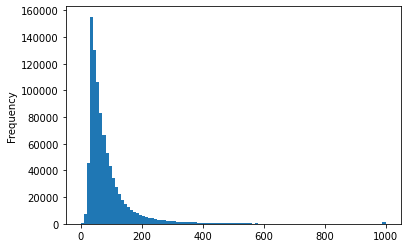

In [58]:
data['len'].clip(upper=1000).plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

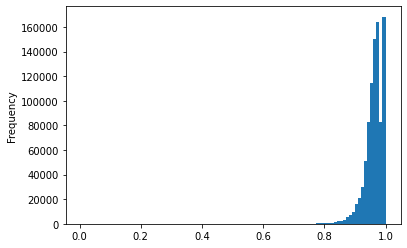

In [61]:
data['len_clean_ratio'].plot.hist(bins=100)

## lettes dict

In [8]:
from collections import Counter

def count_chars(s, chars):
    counter = Counter(s)
    return {c : counter.get(c,0) for c in chars}

letters_dict = Counter([c for s in data['desc'] for c in s])

In [9]:
sorted(letters_dict.items(), key=lambda i: i[1], reverse=True)

[(' ', 11269150),
 ('a', 6918402),
 ('e', 5827493),
 ('o', 5432923),
 ('i', 4519406),
 ('z', 4060100),
 ('n', 3448487),
 ('s', 3133460),
 ('r', 2971734),
 ('k', 2774425),
 ('y', 2761594),
 ('w', 2572928),
 ('t', 2412194),
 ('p', 2306489),
 ('m', 2204999),
 ('c', 2117288),
 ('d', 2068713),
 ('l', 1826311),
 ('b', 1633695),
 ('u', 1422661),
 ('j', 1374134),
 ('.', 1076430),
 ('ł', 1008407),
 (',', 807210),
 ('g', 713406),
 ('ó', 465146),
 ('ę', 448375),
 ('ż', 416814),
 ('P', 367068),
 ('ą', 360837),
 ('h', 338778),
 ('S', 288760),
 ('!', 278291),
 ('ś', 273548),
 ('f', 228596),
 ('\r', 219740),
 ('ć', 212443),
 ('B', 174693),
 ('A', 170350),
 ('W', 166578),
 ('O', 155386),
 ('D', 154107),
 ('T', 147638),
 ('Z', 133755),
 ('J', 133418),
 ('E', 132228),
 ('N', 122486),
 ('K', 104327),
 ('\n', 104190),
 ('M', 102931),
 (')', 99456),
 ('C', 95883),
 ('I', 91000),
 ('-', 84443),
 ('0', 83453),
 ('R', 82176),
 (':', 75159),
 ('L', 61472),
 ('ń', 60901),
 ('1', 58551),
 ('G', 48068),
 ('Y', 40

In [ ]:
# todo: \r, \n, \xa0 to space

## filter alpha num and punctuation

In [22]:
a = '257 najlepszy moment ψψ'
b = 'اغلاق الكلبة العربي يمارس الجنس مع ما يصل'
c = "stara ''sowiecka szkola'' zaczynam sie zastanawiac czy mozna by ich legalnie zdelegalizowac ?"
d = 'Dobrze. Szkoda, że InPost nie precyzuje co oznacza, że dostarcza przesyłkę "OD RANA"'
e = '  asd  asd  '
f = 'łączńie ćma grzegżźółka'
g = 'Bardzo przyjazny klientom sklep. \\Realizuje, wszystkie zamówienai: takie - takie '
h = 'Szanowni Państwo, ODRADZAM !!!\r\r\r\n\r\r\r\n'
i = 'Szanowni Państwo,\r\r\r\n\r\r\r\n ODRADZAM !!!'
j = 'what???????!!!!!!!!!'

tt = [a,b,c,d,e,f,g,h,i,j]

In [25]:


for s in tt:
    c = re.sub(special, ' ', s)
    c = re.sub(alpha, '', c)
    c = re.sub('\s+', ' ', c)
    c = c.strip()
    print(f"len: {len(c)}|{c}|")

len: 20|257 najlepszy moment|
len: 0||
len: 93|stara ''sowiecka szkola'' zaczynam sie zastanawiac czy mozna by ich legalnie zdelegalizowac ?|
len: 84|Dobrze. Szkoda, że InPost nie precyzuje co oznacza, że dostarcza przesyłkę "OD RANA"|
len: 7|asd asd|
len: 23|łączńie ćma grzegżźółka|
len: 78|Bardzo przyjazny klientom sklep. Realizuje, wszystkie zamówienai takie - takie|
len: 30|Szanowni Państwo, ODRADZAM !!!|
len: 30|Szanowni Państwo, ODRADZAM !!!|
len: 20|what???????!!!!!!!!!|


# modeling

## creating dictionaty

In [65]:
import gensim
from gensim import corpora